# RAG & LLM Search AI Sejarah Indonesia Modern 1945-1998

In [ ]:
import os
from dotenv import load_dotenv
import requests
from ddgs import DDGS
from PyPDF2 import PdfReader
from typing import List

load_dotenv()

True

In [ ]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq
from langchain.agents import Tool
from sentence_transformers import SentenceTransformer
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Qdrant
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer

## Wiki Search

In [42]:
def wiki_search(judul_halaman : str) : 
    """
    Digunakan untuk fetch API dari wikipedia
    """
    API_URL = "https://id.wikipedia.org/w/api.php"
    params = {
        "action" : "query",
        "format" : "json",
        "titles" : judul_halaman,
        "prop" : "extracts",
        "explaintext" : True,
        "formatversion" : "2"
    }
    
    headers = {
        "User-Agent" : "AplikasiPengambilSejarah/1.0 (mahindra@email.com)"
    }
    
    try : 
        response = requests.get(url=API_URL,params=params,headers=headers)
        response.raise_for_status()
        data = response.json()
    
        halaman = data["query"]["pages"][0]
    
        if "extract" in halaman : 
            teks_artikel = halaman["extract"]
    
            print(f"Judul : {halaman['title']}\n")
            print("----Mulai Isi Artikel----")
    
            print(teks_artikel)
    
            print('-----Akhir Artikel-------')
        else :
            print(f"Halaman dengan judul {judul_halaman} tidak ditemukan")
    except requests.exceptions.RequestException as e:
        print(f"Gagal terhubung ke API Wikipedia {e}")

wiki_tool = Tool(
        name="Wikipedia Search",
        func=wiki_search,
        description="Gunakan ini untuk mengambil artikel Wikipedia berdasarkan judul halaman."
    )

Agent Wiki Search ini digunakan untuk mencari sumber-sumber sejarah dari halaman wikipedia. 

## DDGS

In [43]:
def ddg_search(query: str):
    """
    Digunakan fetch untuk mencari sumber sejarah pada search enginee
    """
    exception_keyworad = "-https://id.wikipedia.org/wiki/"
    keyword = f"{query} {exception_keyworad}"
    
    try : 
        results = list(DDGS().text(query, 
                               region='id-id', 
                               safesearch='moderate', 
                               timelimit='y', 
                               max_results=10))
        if results :
            first_result_snipped = results[0]['body']
            return first_result_snipped
        else:
            print("Tidak ada hasil yang ditemukan.")
    
    except Exception as e:
        print(f"Terjadi kesalahan saat pencarian: {e}")

search_tool = Tool(
    name="WebSearch",
    func=ddg_search,
    description="Gunakan ini untuk mencari informasi terbaru dari internet."    
)

DDGS digunakan untuk mencari sumber sejarah dari search enginee

## RAG (BOOKS)
1. bung_karno_penjambung_lidah_rakjat_indonesia
2. economists-with-guns-authoritarian-development-and-us-indonesian-relations-1960-1968
3. Jejak Yang Melampaui Zaman
4. Ki Hajar Dewantara
5. SEJARAH INDONESIA - DICKY ARIS SETIAWAN
6. soekarno-mentjapai-indonesia-merdeka
7. tan-malaka-menuju-republik-indonesia

In [7]:
def extract_text_from_pdf(file_path):
    valid_documents = []
    total_pages = len(reader.pages)
    
    reader= PdfReader(file_path)
    text= ""
    for page in reader.pages:
        text += page.extract_text()
    return text

def chunk_text(text,chunk_size=500,overlap=50):
    chunks= []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start += chunk_size - overlap
    return chunks


model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


Model Sentece yang digunakan ini ringan untuk embedding teks menjadi vector. Selain itu model sentece terbaru dapat berjalan dengan cepat memvetorize teks.

In [8]:
def extract_text_from_pdf(file_path :str) -> List[Document]:
    try : 
        valid_documents = []
        
        reader= PdfReader(file_path)
        total_pages = len(reader.pages)
        
        for i,page in enumerate(reader.pages):
            page_number= i +1
            content= None
            
            try : 
                content = page.extract_text()
            
            except Exception as e:
                print(f"Gagal ekstrak teks dari halaman : {page_number}. Error : {e}")
    
            if content is None or len(content.strip())==0:
                print(f"Halaman {page_number} diabaikan : konten teks kosong")
                continue
                
            documents_path, ext = os.path.splitext(file_path)
            doc = Document(
                page_content=content.strip(),
                metadata={
                    "source" : documents_path,
                    "page" : i +1
                }
            )
            valid_documents.append(doc)
        print(f"✅ Berhasil memproses {documents_path} dengan {total_pages} halaman. Ditemukan {len(valid_documents)} halaman valid.")
        return valid_documents
    except Exception as e:
        print(f"Error saat memproses PDF : {e}")
        return []

def chunk_text(documents : List[Document],chunk_size=500,overlap=50) -> List[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size= chunk_size,
        chunk_overlap=overlap,
        length_function=len,
        is_separator_regex=False,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Chunking selesai. Total halaman asli : {len(documents)}")
    return chunks




Database vector yang digunakan adalah Qdrant karena memiliki kecepatan tinggi dan flesibilitas deployment lebih lanjut

In [9]:
def index_to_qdrant(chunks : List[Document], url : str , collection_name : str):
    if not chunks:
        print("❌ Tidak ada chunks yang valid untuk di-index.")
        return

    try:
        # Inisialisasi model embedding yang akan digunakan
        model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

        print(f"⏳ Memulai indexing ke Qdrant Collection: {collection_name}...")
        
        # 2. Indexing Otomatis
        # Qdrant.from_documents secara otomatis menangani:
        # a) Mengubah chunks menjadi embeddings.
        # b) Menyimpan embeddings, teks, dan metadata ke Qdrant.
        Qdrant.from_documents(
            documents=chunks,
            embedding=model,
            url = url,
            collection_name=collection_name,
        )
        
        print("✅ Indexing ke Qdrant Selesai!")

    except Exception as e:
        print(f"❌ Gagal Indexing ke Qdrant. Cek koneksi atau API Key Anda. Error: {e}")


qdrant_url = "http://localhost:6333"
collection_name = 'book_knowledge'

folder = "./books"

for filename in os.listdir(folder) :
    if filename.endswith(".pdf") : 
        book_path = os.path.join(folder,filename)
        text_book = extract_text_from_pdf(book_path)
        
        chunk = chunk_text(text_book)
        
        index_to_qdrant(chunks=chunk,collection_name=collection_name,url=qdrant_url)


Halaman 2 diabaikan : konten teks kosong
✅ Berhasil memproses ./books/Ki Hajar Dewantara dengan 210 halaman. Ditemukan 209 halaman valid.
Chunking selesai. Total halaman asli : 209


/tmp/ipykernel_193005/1816697103.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


⏳ Memulai indexing ke Qdrant Collection: book_knowledge...
✅ Indexing ke Qdrant Selesai!
Halaman 1 diabaikan : konten teks kosong
Halaman 2 diabaikan : konten teks kosong
✅ Berhasil memproses ./books/tan-malaka-menuju-republik-indonesia dengan 58 halaman. Ditemukan 56 halaman valid.
Chunking selesai. Total halaman asli : 56
⏳ Memulai indexing ke Qdrant Collection: book_knowledge...
✅ Indexing ke Qdrant Selesai!
✅ Berhasil memproses ./books/SEJARAH INDONESIA - DICKY ARIS SETIAWAN dengan 6 halaman. Ditemukan 6 halaman valid.
Chunking selesai. Total halaman asli : 6
⏳ Memulai indexing ke Qdrant Collection: book_knowledge...
✅ Indexing ke Qdrant Selesai!
Halaman 1 diabaikan : konten teks kosong
Halaman 2 diabaikan : konten teks kosong
✅ Berhasil memproses ./books/soekarno-mentjapai-indonesia-merdeka dengan 83 halaman. Ditemukan 81 halaman valid.
Chunking selesai. Total halaman asli : 81
⏳ Memulai indexing ke Qdrant Collection: book_knowledge...
✅ Indexing ke Qdrant Selesai!
Halaman 1 diaba

In [10]:
def get_qdrant_retriever():
       
    embedding = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
    url = "http://localhost:6333"
    collection_name = "book_knowledge"
    client = QdrantClient(url=url)
    
    qdrant = Qdrant(
        client=client,
        collection_name=collection_name, # <== Penentuan COLLECTION
        embeddings=embedding,
    )
    retriever = qdrant.as_retriever(search_kwargs={"k" : 4})
    return retriever
    
qdrant_retriever = get_qdrant_retriever()

/tmp/ipykernel_193005/1723501507.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  qdrant = Qdrant(


In [34]:
#test qdrant retriver

promt = "Mengapa Soekarno digulingkan?"
if qdrant_retriever : 
    test_query = promt
    retrieved_docs = qdrant_retriever.invoke(test_query)
    print(f"Jumlah dokumen yang diambil: {len(retrieved_docs)}")
    for doc in retrieved_docs:
        print(f"Isi Dokumen: {doc.page_content[:100]}...") # Cetak 100 karakter pertama
        print(f"Metadata: {doc.metadata}")


Jumlah dokumen yang diambil: 4
Isi Dokumen: Sekilas Tentang Langkah  Perjuangan  Soewardi  209...
Metadata: {'source': './books/Ki Hajar Dewantara', 'page': 209, '_id': '56260c4e-9915-4c94-af21-34e7717274fd', '_collection_name': 'book_knowledge'}
Isi Dokumen: Sekilas Tentang Langkah  Perjuangan  Soewardi  209...
Metadata: {'source': './books/Ki Hajar Dewantara', 'page': 209, '_id': '0b552605-c616-4b1b-b3f4-d7762f023382', '_collection_name': 'book_knowledge'}
Isi Dokumen: Sekilas Tentang Langkah  Perjuangan  Soewardi  209...
Metadata: {'source': './books/Ki Hajar Dewantara', 'page': 209, '_id': 'f813c4fc-c618-446d-a177-1093bb9d2603', '_collection_name': 'book_knowledge'}
Isi Dokumen: kami. Selain itu kami menerima orang bajar-makan, sekalipun rumah kami di Djalan Dewi Sartika 22 ket...
Metadata: {'source': './books/bung_karno_penjambung_lidah_rakjat_indonesia_', 'page': 47, '_id': '2ef2a8a3-2528-42eb-95c5-9955dbbef9ac', '_collection_name': 'book_knowledge'}


In [47]:
#tool retrieval

@tool
def retrieve_from_vector_store(query: str) -> str:
    """
    Gunakan tool ini untuk mengambil konteks dan informasi dari basis data pengetahuan (Qdrant).
    Gunakan QUERY yang spesifik dan jelas.
    """
    if qdrant_retriever is None:
        return "Error: Retriever tidak tersedia."

    print(f"⚙️ Agent memanggil Qdrant dengan query: '{query}'")
    
    # Memanggil retriever untuk mendapatkan dokumen yang relevan
    docs: List[Document] = qdrant_retriever.invoke(query)
    
    # Memformat dokumen menjadi string konteks
    context = "\n\n".join([
        f"Dokumen Halaman {doc.metadata.get('page', 'N/A')}: {doc.page_content}" 
        for doc in docs
    ])
    
    if not context:
         return "Tidak ada informasi relevan yang ditemukan dalam basis data pengetahuan."

    return f"Konteks yang Ditemukan:\n---\n{context}\n---"

# Tool yang siap digunakan
qdrant_tool = retrieve_from_vector_store

Agent diatas merupakan pengambilan data dari database vector qdrant.

## Agent AI

In [118]:
from typing import TypedDict, Any
from typing_extensions import Annotated
import operator
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage, AIMessage
from langchain_core.runnables import Runnable

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    
class Agent:

    def __init__(self, model: Runnable, tools: List[Any], system: str = "", temperature: float = 0.0):
        self.system = system
        self.temperature = temperature # <== Menyimpan temperature
        
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        
        # VVVVVV MODIFIKASI UTAMA VVVVVV
        # 1. Gunakan .bind() untuk mengatur parameter temperature
        # 2. Kemudian gunakan .bind_tools()
        self.model = model.bind(temperature=self.temperature).bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]

        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
            
        message = self.model.invoke(messages) 
        return {'messages': [message]}
        
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t['name']} with args: {t['args']}")
            if not t['name'] in self.tools:     
                print("\n ....bad tool name....")
                result = "bad tool name, retry" 
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
            
        print("Back to the model!")
        return {'messages': results}
    def run(self, prompt: str) : 
        """
        Menjalankan agent tanpa menampilkan seluruh struktur pesan
        """

        messages = [HumanMessage(content=prompt)]
        result = self.graph.invoke({"messages": messages})

        for msg in reversed(result["messages"]):
            if isinstance(msg, AIMessage) and msg.content.strip():
                return msg.content
        return "(Tidak ada jawaban yang dihasilkan)"
        
    def ringkas_teks(self,teks: str, panjang_ringkasan : str = "pendek") -> str:
        """
        Meringkas teks panjang menggunakan LLM yang sudah di-bind ke agent.
        
        Args:
            teks (str): Teks yang akan diringkas.
            panjang_ringkasan (str): 'pendek', 'sedang', atau 'panjang'.
        Returns:
            str: Hasil ringkasan teks.
        """
        prompt = f"""
        Buat ringkasan {panjang_ringkasan} dari teks berikut dengan gaya akademik dan informatif.
        Fokus pada ide utama dan informasi penting.
        ---
        {teks}
        ---
        Ringkasan:
        """
        try:
            hasil = self.model.invoke(prompt)
            if hasattr(hasil, "content"):
                return hasil.content.strip()
            else:
                return str(hasil).strip()
        except Exception as e:
            return f"Gagal meringkas teks: {e}"

In [133]:
llm = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct",api_key=api_key)

Model LLM terbaru dapat memberikan hasil signifikan dalam pengelolaan agent tool seperti hasil sesuai yang diberikan promt dan kontent yang ditampilkan tersusun rapi

In [134]:
template = """
Kamu adalah sejarawan AI yang pandai merangkum fakta sejarah Indonesia.
Gunakan bahasa yang jelas, formal, dan bernuansa akademik.
Ringkas teks berikut menjadi narasi sejarah yang padat, kronologis, dan mudah dipahami.
Gunakan seluruh agent AI untuk mencari referensi sejarah.
"""

In [136]:
tools = [
    wiki_tool,
    search_tool,
    retrieve_from_vector_store,
]

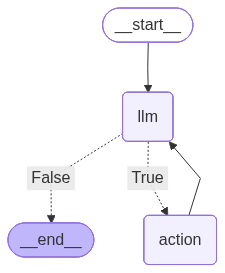

In [137]:
from IPython.display import Image, display

api_key = os.getenv('GROQ_API_KEY')

agent = Agent(model=llm,tools=tools, system=template)

display(Image(agent.graph.get_graph().draw_mermaid_png()))



In [138]:
messages = "Mengapa Soekarno Digulingkan"

print("---------------------Hasil Penelurusan AI-------------------------")

result = agent.run(messages)


print("---------------------Berikut Ringkasan Sejarahnya-------------------------")
ringkasan_teks = agent.ringkas_teks(result,panjang_ringkasan="pendek")
print(result)

---------------------Hasil Penelurusan AI-------------------------
Calling: retrieve_from_vector_store with args: {'query': 'Soekarno digulingkan'}
⚙️ Agent memanggil Qdrant dengan query: 'Soekarno digulingkan'
Calling: WebSearch with args: {'__arg1': 'Mengapa Soekarno Digulingkan'}
Calling: Wikipedia Search with args: {'__arg1': 'Peristiwa 30 September 1965'}
Halaman dengan judul Peristiwa 30 September 1965 tidak ditemukan
Back to the model!
---------------------Berikut Ringkasan Sejarahnya-------------------------
Soekarno, Presiden pertama Indonesia, digulingkan dari jabatannya pada tahun 1966, setelah peristiwa 30 September 1965 (G30S). Peristiwa ini merupakan sebuah gerakan yang dilakukan oleh anggota militer dan beberapa kelompok lainnya yang menuduh Soekarno terlibat dalam upaya kudeta.

Berikut adalah ringkasan kronologis peristiwa yang menyebabkan Soekarno digulingkan:

1. **Peristiwa 30 September 1965 (G30S):** Gerakan 30 September yang dipimpin oleh Letnan Kolonel Untung Sya

In [143]:
messages = "Apa yang menjadikan soeharto layak menjadi presiden?"

print("---------------------Hasil Penelurusan AI-------------------------")

result = agent.run(messages)


print("---------------------Berikut Ringkasan Sejarahnya-------------------------")
ringkasan_teks = agent.ringkas_teks(result,panjang_ringkasan="pendek")
print(result)

---------------------Hasil Penelurusan AI-------------------------
Calling: WebSearch with args: {'__arg1': 'Soeharto menjadi Presiden Indonesia'}
Back to the model!
Calling: retrieve_from_vector_store with args: {'query': 'Kelayakan Soeharto menjadi Presiden Indonesia'}
⚙️ Agent memanggil Qdrant dengan query: 'Kelayakan Soeharto menjadi Presiden Indonesia'
Back to the model!
---------------------Berikut Ringkasan Sejarahnya-------------------------
Soeharto menjadi Presiden Indonesia setelah menggantikan Sukarno pada tahun 1967. Ia dipilih oleh Majelis Permusyawaratan Rakyat (MPR) sebagai Presiden RI menggantikan Sukarno karena dinilai lebih stabil dan mampu mengatasi krisis ekonomi dan politik yang melanda Indonesia pada saat itu. Soeharto kemudian menjabat sebagai Presiden selama 31 tahun, hingga lengser pada 21 Mei 1998.


**Hasil Evaluasi** 
<br>
<br>
Pembuatan Search AI dari RAG dan LLM pada tema **Sejarah Indonesia Modern 1945-1998** masih terdapat kendala error yang belum pasti dan harus dijanlankan kedua kali agar LLM dapat berjalan. Hasil penulusan menggunakan agent tools tidak digunakan semuanya hanya beberapa saja alias tidak stabil. <br>
Agent yang digunakan : 
1. Wikipedia
2. Qdrant Database untuk menyimpan vector teks dari sumber PDF
3. Search engginee DuckDuckGo

<br>



